# Investigate the sensitivity to the fossil fuel oxidative ratio

In [1]:
import os, glob
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from collections import OrderedDict
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.config.paths import Paths

import apo_emiss_func

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Inputs

In [2]:
year = 2015        # the year to study
month = 8           # the month to study
uncertainty = {'flux': 10, 'OR': 3}     # uncertainty in the flux and ff oxidative ratio, per cent
sigma = 3           # the number of sigma uncertainty to plot
number = 1_000      # the number of Monte Carlo runs

variable = 'flux' #'or'

ocean_o2_model = 'nemo'

fontsize = 16       # the fontsize to use when plotting

# the sectors to include
sectors_ff = ['energyprod', 'indproc', 'offshore', 'roadtrans', 'domcom', 'indcom', 'othertrans']

# oxidative ratio for each fuel type
ox_ratio_fuels = {'Coal' : -1.17, 'Oil' : -1.44, 'Gas' : -1.95, 'Peat' : -1.05, 'Biomass' : -1.1, 'Methane' : -2.0}
ox_ratio_fuels = {'Coal' : -1.17, 'Oil' : -1.44, 'Gas' : -1.95, 'Cement' : 0, 'Non-combustion': 0, 'Methane' : -2.0}

# the identifier for the filenames for each source type
file_ident = {'bc': 'bc',
              'bio': 'bio_orchidee',
              'ff': 'ff',
              'ocean': 'ocean'}

# get the start and end date from the year and month above
start = f'{year}-{str(month).zfill(2)}-01'
end = datetime(year, month, 1) + relativedelta(months=1, hours=-1)

date_str = f'{year}{str(month).zfill(2)}'
uncertainty_filename = os.path.join('/user', 'work', 'vf20487', 'Sensitivities', f'APO_uncertainties_{date_str}.nc')

## Get the data

Get the timeseries data for each fossil fuel sector

In [12]:
ts_path = os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'o2_co2')  # path to the timeseries files
ts_files = glob.glob(os.path.join(ts_path, f'WAO_ff-ukghg-*{year}.nc'))

print('Files:')
[print(f'- {ts_file}') for ts_file in ts_files]

# open the timeseries files and slice the data to the correct time period
if len(ts_files)==1 and 'sectors' in ts_files[0]:
    ts_data = name.open_ds(ts_files[0])
    sectors = list(set([sector.split('-')[1] for sector in ts_data.data_vars]))
    ts_data = {sector: {species: ts_data[f'{species}-{sector}'].sel(time=slice(start, end))
                        for species in ['co2', 'o2']}
               for sector in  sectors}
else:
    ts_data = {ff.split('ukghg-')[1].split('_time')[0]: name.open_ds(ff) for ff in ts_files}
    ts_data = {sector: ts_sector.sel(time=slice(start, end))
            for sector, ts_sector in ts_data.items()}

Files:
- /user/work/vf20487/Timeseries/o2_co2/WAO_ff-ukghg-sectors_timeseries_2015.nc


## Get the fuel use data

In [4]:
fuel_use_file = glob.glob(os.path.join(Paths.data, 'Gridded_fluxes', 'CO2', 'NAEI', '*Fuel*.nc'))[0]
fuel_use_data = name.open_ds(fuel_use_file)

sectors = fuel_use_data.snap_sectors.values
fuels   = fuel_use_data.fuel_groups.values

# get the indices associated with each fuel and sector
#     - the indices are used as a coordinate in the xarray DataArray
fuel_indices = {fuel: fuel_use_data.Fuel_Group[fuel_use_data.fuel_groups==fuel].values[0]
                for fuel in fuels}
sector_indices = {sector: fuel_use_data.Sector[fuel_use_data.snap_sectors==sector].values[0]
                  for sector in sectors if sector in sectors_ff}

## Get the fuel-based timeseries

- Use the fuel usage data for each sector to calculate the proportion of emissions for each sector associated with each fuel
- Use the proportion information to calculate timeseries for each fuel within each sector

In [13]:
fuel_year = year if year in fuel_use_data.Year else np.nanmax(fuel_use_data.Year)
print(f'Using fuel data for {fuel_year}')

proportion = {sector: {fuel : float(fuel_use_data.Proportion_of_sector.sel(Sector = sector_index,
                                                                           Fuel_Group = fuel_index,
                                                                           Year = fuel_year))
                       for fuel, fuel_index in fuel_indices.items()}
              for sector, sector_index in sector_indices.items()}
# remove fuel types that don't contribute in each sector
proportion = {sector: {fuel: prop_fuel for fuel, prop_fuel in prop_sector.items()
                      if not np.isnan(prop_fuel) and fuel in ox_ratio_fuels.keys()}
              for sector, prop_sector in proportion.items()}
    
# multiply the timeseries by the proportions data
ts_fuel = {sector: {fuel: (ts_data[sector]['o2'] * prop_fuel)
                    for fuel, prop_fuel in prop_sector.items()}
           for sector, prop_sector in proportion.items()}
ts_fuel = {sector: {fuel: ts.values for fuel, ts in ts_sector.items()}
           for sector, ts_sector in ts_fuel.items()}

Using fuel data for 2015


## Uncertainty in flux

In [14]:
ts_fuel['domcom'].keys()

o2_flux_uncertainty = {sector: {fuel: (ox_ratio_fuels[fuel] * uncertainty['flux']*1e-2 * ts)**2
                                for fuel, ts in ts_sector.items()}
                       for sector, ts_sector in ts_fuel.items()}
o2_flux_uncertainty = {sector: sum(unc_sector.values())
                       for sector, unc_sector in o2_flux_uncertainty.items()}
o2_flux_uncertainty_tot = sum(o2_flux_uncertainty.values())**0.5
o2_flux_uncertainty = {sector: unc_sector**0.5 for sector, unc_sector in o2_flux_uncertainty.items()}

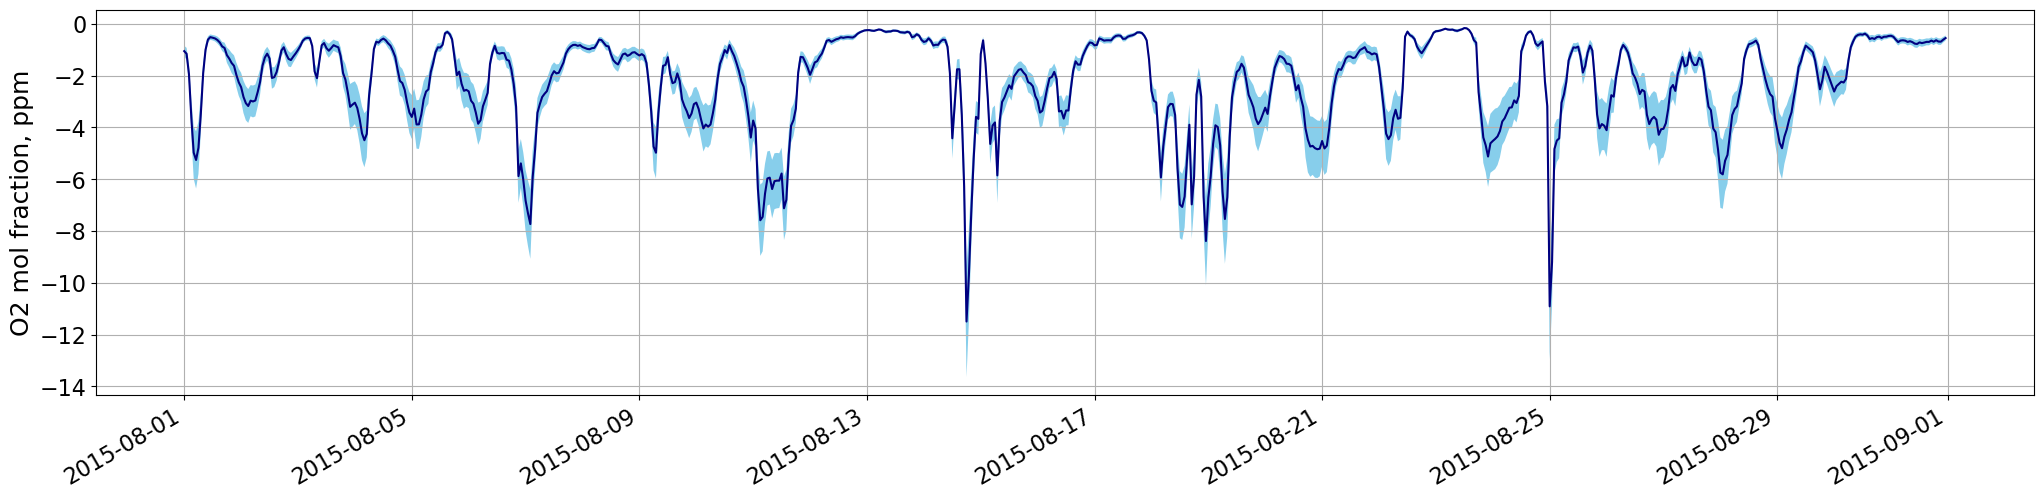

In [15]:
ts_o2_all = sum({sector: ts_sector['o2'] for sector, ts_sector in ts_data.items()}.values())

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

unc_plot = plt.fill_between(ts_o2_all.time,
                            ts_o2_all.values - o2_flux_uncertainty_tot*sigma,
                            ts_o2_all.values + o2_flux_uncertainty_tot*sigma,
                            facecolor='skyblue')
plot = ts_o2_all.plot(ax=ax, color='navy')

grid = ax.grid()
xlab = ax.set_xlabel('')
ylab = ax.set_ylabel('O2 mol fraction, ppm', fontsize=fontsize+2)
ticks = ax.tick_params(labelsize=fontsize)

In [16]:
attrs_unc = {'units': 'per meg',
             'sigma': 1,
             'description': 'uncertainty associated with the oxygen fossil fuel flux',
             'ffCO2 uncertainty assumed': f'{uncertainty["flux"]} per cent'}

apo_uncertainty_ds = name.open_ds(uncertainty_filename)
apo_uncertainty_ds[f'o2_ff_flux_{ocean_o2_model}'] = xr.DataArray(data = o2_flux_uncertainty_tot/0.20946,
                                                                  dims = ['time'],
                                                                  coords = {'time': ts_o2_all.time},
                                                                  attrs = attrs_unc)
print(uncertainty_filename)
apo_uncertainty_ds.to_netcdf(uncertainty_filename)

/user/work/vf20487/Sensitivities/APO_uncertainties_201508.nc


Plotting 3 sigma uncertainty


ValueError: operands could not be broadcast together with shapes (744,) (8760,) 

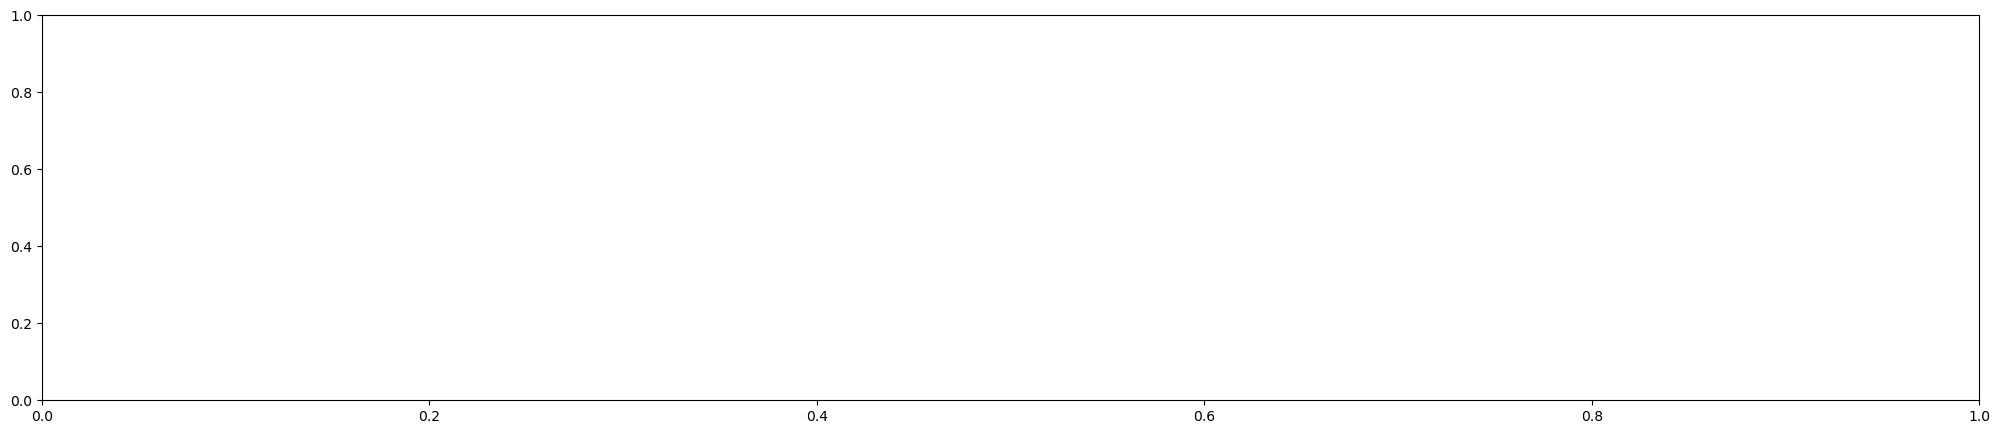

In [34]:
print(f'Plotting {sigma} sigma uncertainty')

apo_uncertainty_o2 = o2_flux_uncertainty_tot / 0.20946
apo_uncertainty_sigma = sigma * apo_uncertainty_o2

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

unc_plot = plt.fill_between(apo_uncertainty_ds.time,
                            apo_uncertainty_ds['model_nemo'].values - apo_uncertainty_sigma,
                            apo_uncertainty_ds['model_nemo'].values + apo_uncertainty_sigma,
                            facecolor='skyblue')
apo_plot = apo_uncertainty_ds['model_nemo'].plot(ax=ax, color='navy')

grid = ax.grid()
xlab = ax.set_xlabel('')
ylab = ax.set_ylabel('APO mf, per meg', fontsize=fontsize+2)
ticks = ax.tick_params(labelsize=fontsize)

## Run the Monte Carlo

Run the Monte Carlo, where the oxidative ratio for each fuel is varied multiple times using a Gaussian distribution and the total ffO2 timeseries is calculated each time

In [39]:
# make a copy of the oxidative ratio dict which will not be altered
ox_ratio_fuel_expected = dict(ox_ratio_fuels)

# zeros arrays to fill with the results from the Monte Carlo runs
o2_all = {fuel: np.zeros((int(number)+1, int(len(ts_data['roadtrans']['o2'].time))))
          for fuel in ox_ratio_fuel_expected.keys()}
o2_sectors = {sector: {fuel: np.zeros((int(number)+1, int(len(ts_data['roadtrans']['o2'].time))))
                       for fuel in ox_ratio_fuel_expected.keys()}
              for sector in sectors_ff}

for fuel_to_vary, ox_ratio_fuel in ox_ratio_fuels.items():
    # generate values of oxidative ratio using the expected value, and the uncertainty
    ox_ratio_fuel = np.insert(np.random.normal(loc = ox_ratio_fuel,
                                               scale = abs(ox_ratio_fuel) * uncertainty["OR"] * 1e-2,
                                               size = int(number)),
                                               0, ox_ratio_fuel)

    for num, oxratio in enumerate(ox_ratio_fuel):
        # create a new dict of ox ratios, with the current value for the varied fuel
        ox_ratios = {fuel: or_fuel if fuel!=fuel_to_vary else oxratio
                    for fuel, or_fuel in ox_ratio_fuel_expected.items()}
        
        o2_num = None
        for sector, ts_sector in ts_fuel.items():
            # multiply the timeseries for each fuel by the corresponding oxidative ratio
            o2_ts_fuel = {fuel: ts_sector_fuel * ox_ratios[fuel]
                          for fuel, ts_sector_fuel in ts_sector.items() if fuel in ox_ratios.keys()}
            # sum the timeseries for all fuels
            o2_sectors[sector][fuel_to_vary][num, :] = sum(o2_ts_fuel.values()) 
            # add the timeseries for this sector to a total for oxygen
            if o2_num is None: 
                o2_num = sum(o2_ts_fuel.values()) 
            else:
                o2_num += sum(o2_ts_fuel.values()) 
        
        # add the timeseries for this run to the array for all runs
        o2_all[fuel_to_vary][num, :] = o2_num

## Calculate the uncertainty

Take the standard deviation from all of the timeseries from the Monte Carlo run - this is the 1 $\sigma$ uncertainty

Plot this for each fuel

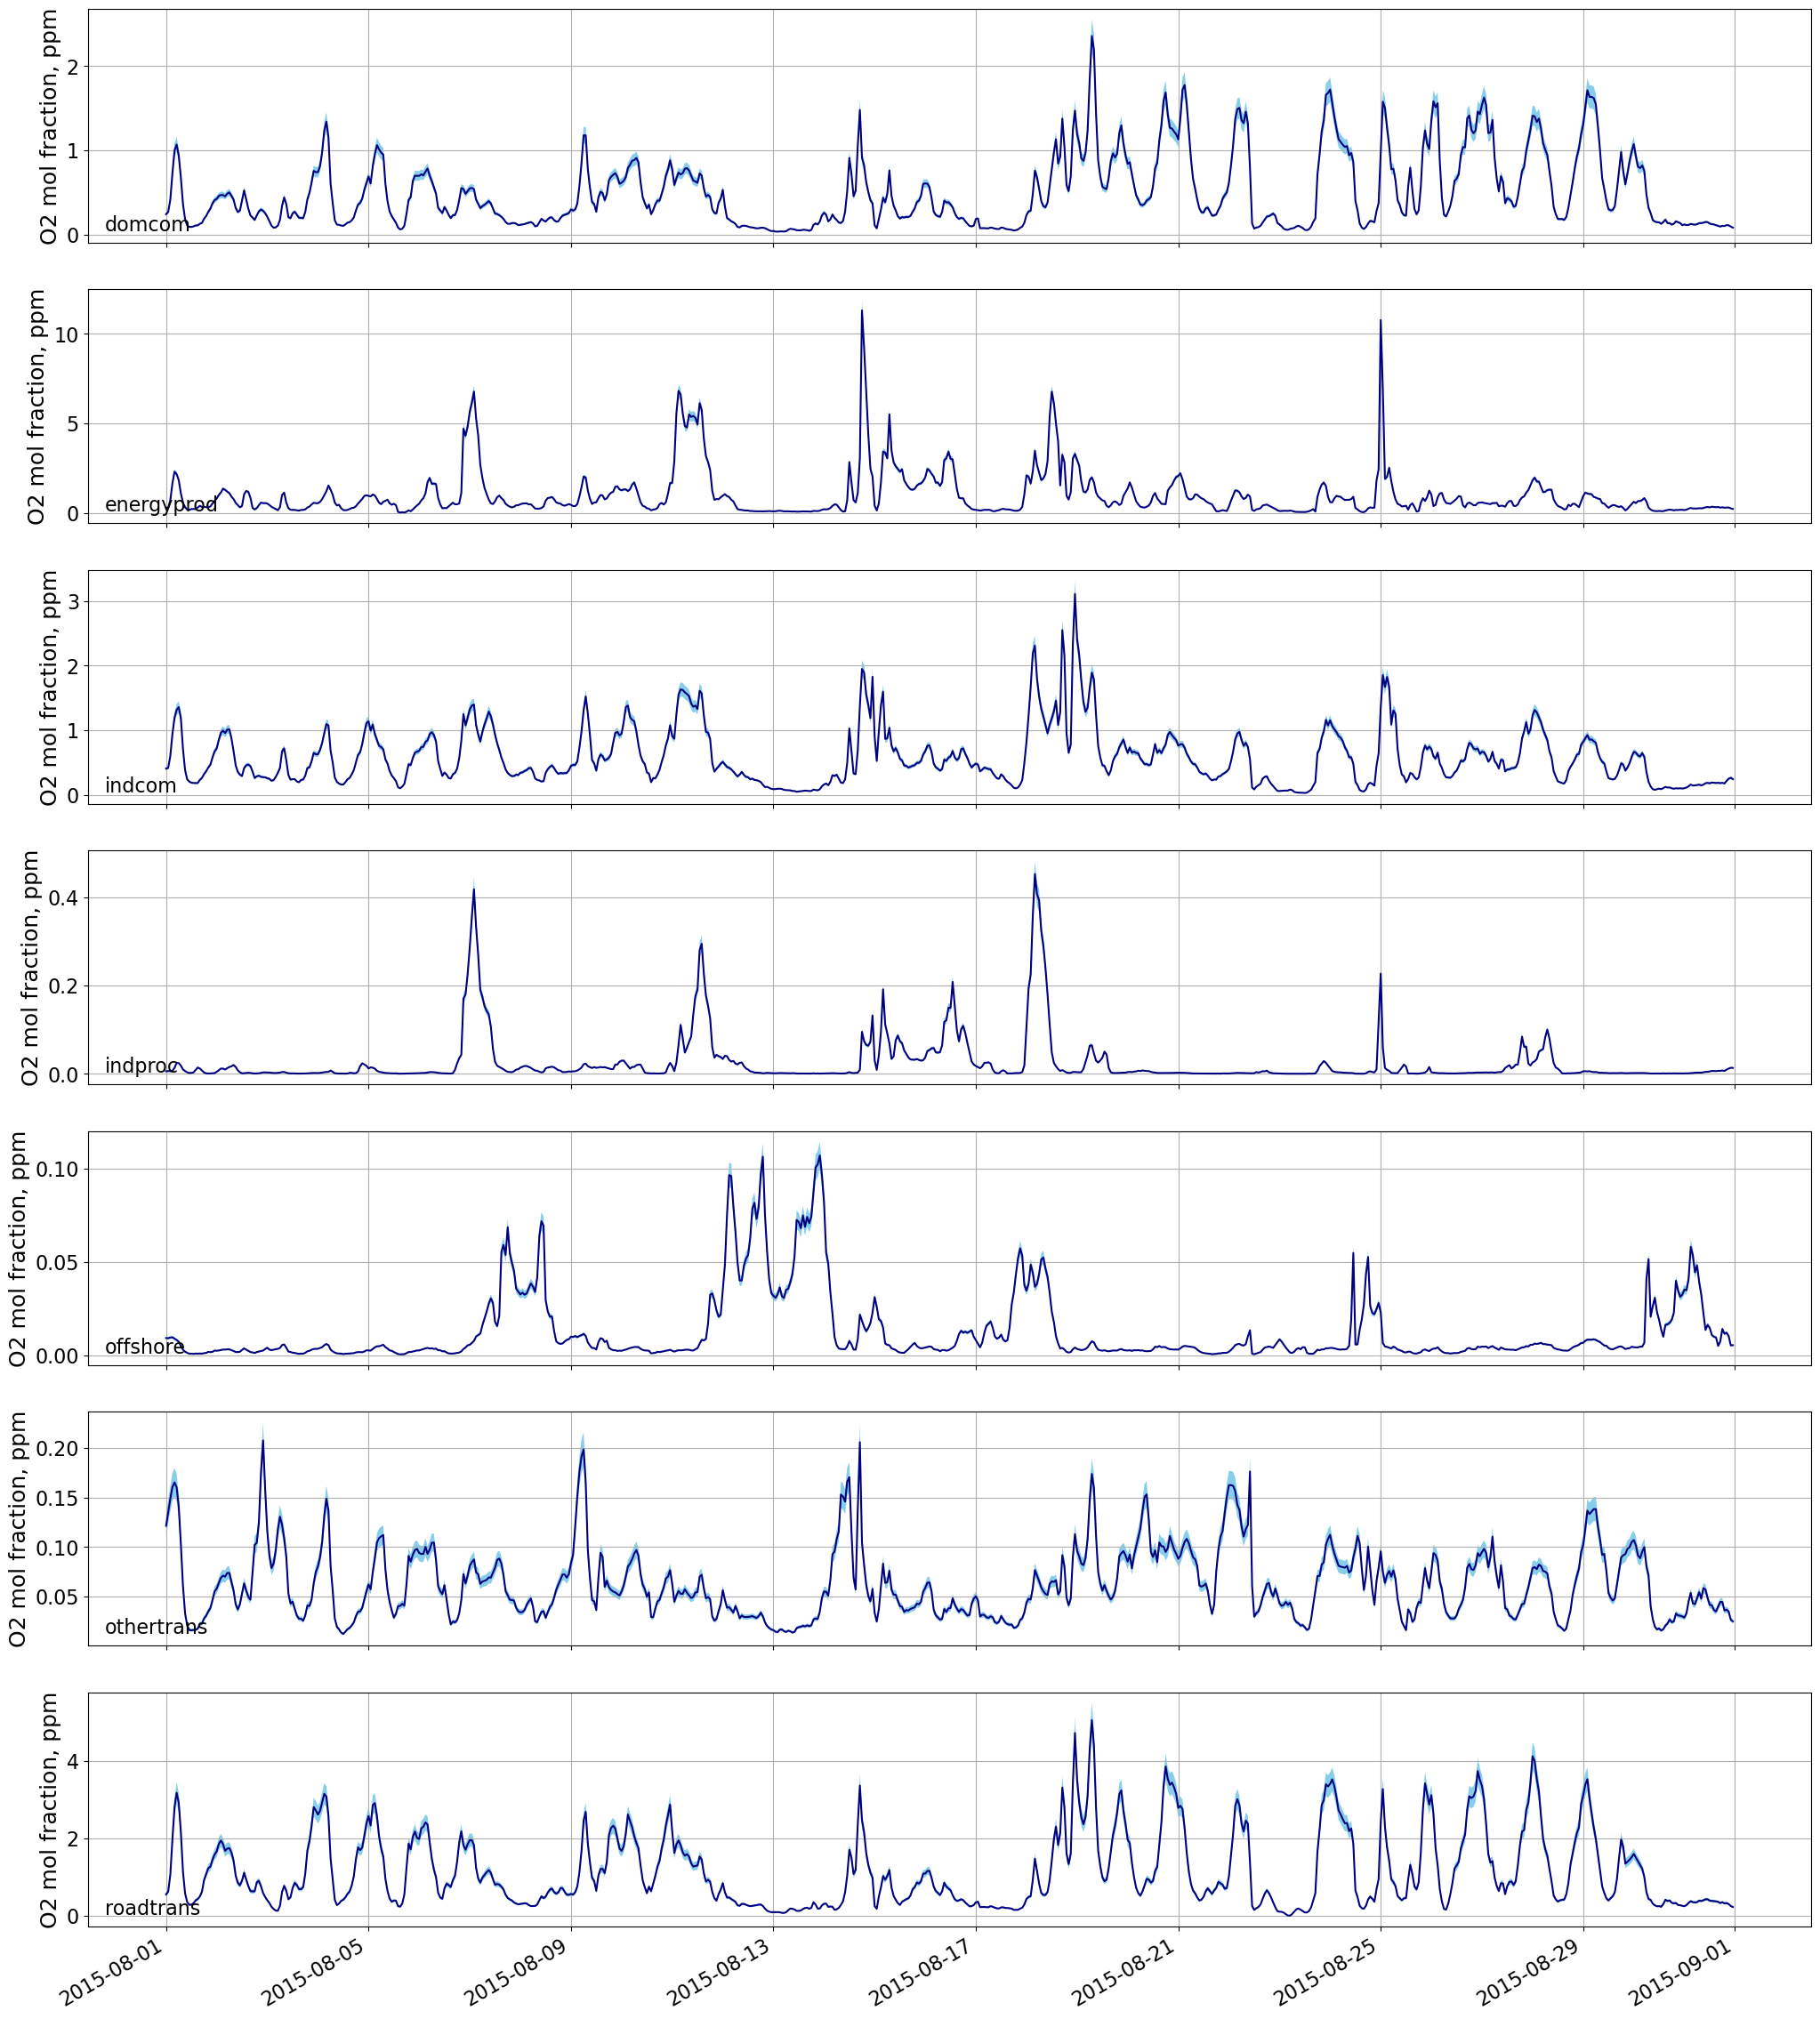

In [41]:
# take the standard deviation of all runs and sum all fuels for each sector
o2_std_sectors = {sector: {fuel: (o2_sec_fuel[1:,:].std(axis=0))**2
                           for fuel, o2_sec_fuel in o2_sector.items()}
                  for sector, o2_sector in o2_sectors.items()}
o2_std_sectors = {sector: np.sqrt(sum(o2_std_sector.values()))
                  for sector, o2_std_sector in o2_std_sectors.items()}

# convert to a datarray
o2_std_sectors = {sector: xr.DataArray(data = o2_std_sectors,
                                       coords = {'time': ts_data[sector]['o2'].time},
                                       dims = ['time'])
                  for sector, o2_std_sectors in o2_std_sectors.items()}
# get the required number of sigma and select the date range need
uncertainty_sectors = {sector: sigma * o2_std_sector.sel(time=slice(start, end))
                       for sector, o2_std_sector in o2_std_sectors.items()}

# convert the timeseries with the expected OR values to a data array
o2_ts_sectors = {sector: xr.DataArray(data = o2_sector['Oil'][0,:],
                                      coords = {'time': ts_data[sector]['o2'].time},
                                      dims = ['time'])
                 for sector, o2_sector in o2_sectors.items()}
# select the date range need and remove any timeseries with all zeros
o2_ts_sectors = {sector: o2_ts_sector.sel(time=slice(start, end))
                 for sector, o2_ts_sector in o2_ts_sectors.items()}
o2_ts_sectors = {sector: o2_ts_sector for sector, o2_ts_sector in o2_ts_sectors.items()
                 if not (o2_ts_sector==0).all()}

fig, axes = plt.subplots(ncols=1, nrows=len(o2_ts_sectors.keys()), figsize=(25, 4*len(o2_ts_sectors.keys())), sharex=True)

o2_ts_sectors = OrderedDict(sorted(o2_ts_sectors.items()))
for aa, (sector, o2_ts_sector) in enumerate(o2_ts_sectors.items()):
    unc_plot = axes[aa].fill_between(o2_ts_sector.time,
                                o2_ts_sector - uncertainty_sectors[sector],
                                o2_ts_sector + uncertainty_sectors[sector],
                                facecolor='skyblue')
    plot = o2_ts_sector.plot(ax=axes[aa], color='navy')
    sector_text = axes[aa].text(0.01, 0.05, sector, transform=axes[aa].transAxes, fontsize=fontsize)

    grid = axes[aa].grid()
    xlab = axes[aa].set_xlabel('')
    ylab = axes[aa].set_ylabel('O2 mol fraction, ppm', fontsize=fontsize+2)
    ticks = axes[aa].tick_params(labelsize=fontsize)

# filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', 'APO_timeseries_ORff_sensitivity.png')
# print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad=0)

## Calculate the total uncertainty

Add together the uncertainty for each fuelto find a total uncertainty for ffO2

Saving to /user/work/vf20487/Figures/Timeseries/Sensitivity/O2_timeseries_ORff_sensitivity_201508.png


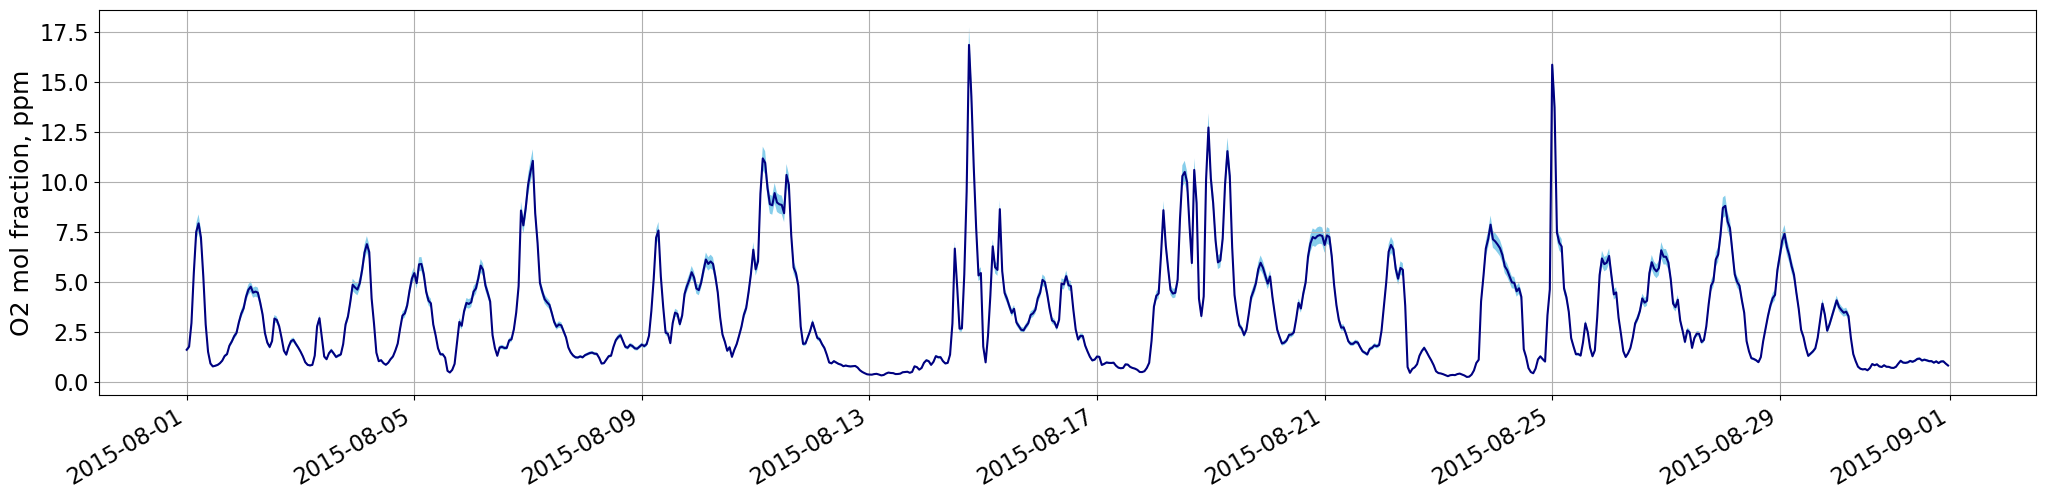

In [42]:
o2_std = {fuel: (o2_all_fuel[1:,:].std(axis=0))**2
          for fuel, o2_all_fuel in o2_all.items()}
o2_std = np.sqrt(sum(o2_std.values()))

o2_std = xr.DataArray(data = o2_std,
                      coords = {'time': ts_data[sector]['o2'].time},
                      dims = ['time'])

o2_ts = xr.DataArray(data = o2_all['Oil'][0,:],
                     coords = {'time': ts_data[sector]['o2'].time},
                     dims = ['time'])

uncertainty_ts = sigma * o2_std.sel(time=slice(start, end))
o2_ts = o2_ts.sel(time=slice(start, end))

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

unc_plot = plt.fill_between(o2_ts.time,
                            o2_ts - uncertainty_ts,
                            o2_ts + uncertainty_ts,
                            facecolor='skyblue')
plot = o2_ts.plot(ax=ax, color='navy')

grid = ax.grid()
xlab = ax.set_xlabel('')
ylab = ax.set_ylabel('O2 mol fraction, ppm', fontsize=fontsize+2)
ticks = ax.tick_params(labelsize=fontsize)

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'O2_timeseries_ORff_sensitivity_{date_str}.png')
print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0)

## Calculate the APO sensitivity

So far we have looked at the O2 sensitivity to the oxidative ratios, now we model APO to see its sensitivity

In [43]:
timeseries_path = os.path.join('/user', 'work', 'vf20487', 'Timeseries', 'o2_co2')
timeseries_files = {source: glob.glob(os.path.join(timeseries_path, f'WAO_{ident_source}_timeseries_{year}.nc'))[0]
                    for source, ident_source in file_ident.items()}

print_files = [print(f'{source}: {file_source}') for source, file_source in timeseries_files.items()]

timeseries_data = {source: name.open_ds(file_source) for source, file_source in timeseries_files.items()}
timeseries_data = {source: ts_source.sel(time=slice(start, end)) for source, ts_source in timeseries_data.items()}

# # make sure the units are correct
for source, ts_source in timeseries_data.items():
    for vv in ts_source.data_vars:
        ts_source[vv] = ts_source[vv] *1e6 if all(abs(ts_source[vv])<1e-4) else ts_source[vv]

bc: /user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc
bio: /user/work/vf20487/Timeseries/o2_co2/WAO_bio_orchidee_timeseries_2015.nc
ff: /user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc
ocean: /user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc


### Calculate the uncertainty

In [44]:
apo_ff_uncertainty = apo_emiss_func.apo_species_split(ff_co2 = timeseries_data['ff']['co2'],
                                                      ff_o2 = uncertainty_ts,
                                                      oxidative_ratio_bio = 1.07,
                                                      convert = False)['co2_ff']
apo_uncertainty = np.sqrt((timeseries_data['ff']['co2'] * uncertainty_ts)**2)

### Calculate the APO model

In [46]:
apo_model_split = apo_emiss_func.apo_species_split(ocean_o2 = timeseries_data['ocean'][f'o2_{ocean_o2_model}_day'],
                                                   ff_co2 = timeseries_data['ff']['co2'],
                                                   ocean_co2 = timeseries_data['ocean'][f'co2_{ocean_o2_model}_mth'],
                                                   ocean_n2 = timeseries_data['ocean']['n2_nemo_day'],
                                                   ff_o2 = timeseries_data['ff']['o2'],
                                                   oxidative_ratio_bio = 1.07,
                                                   convert = False)
apo_model = apo_model_split['co2_ff'] + apo_model_split['co2_ocean'] + apo_model_split['n2_ocean'] + apo_model_split['o2_ocean'] + timeseries_data['bc'].apo

### Plot the model with the sensitivity as shading

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Plotting 3 sigma uncertainty
Saving to /user/work/vf20487/Figures/Timeseries/Sensitivity/APO_timeseries_ORff_sensitivity_3sigma_201508.png


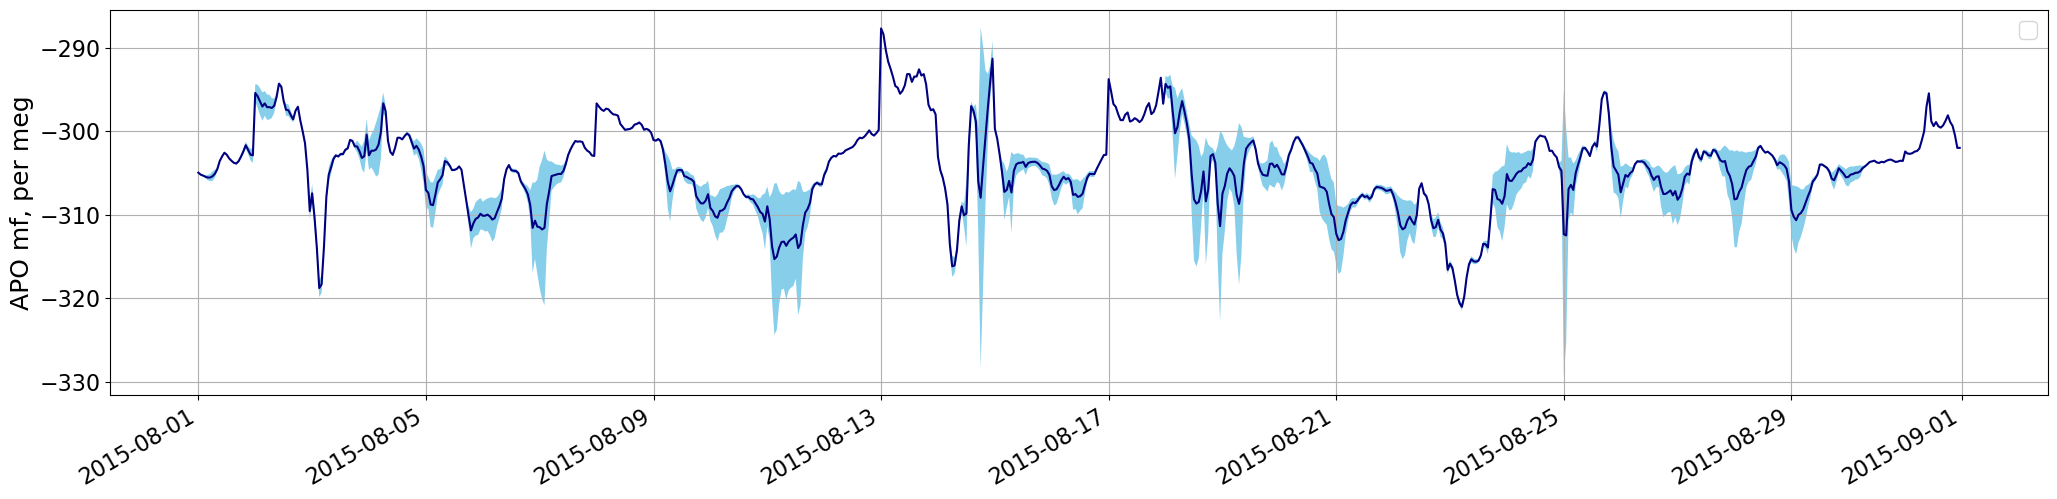

In [47]:
print(f'Plotting {sigma} sigma uncertainty')

apo_uncertainty_sigma = sigma * apo_uncertainty

fig, ax = plt.subplots(1, 1, figsize=(25, 5))

unc_plot = plt.fill_between(apo_model.time,
                            apo_model - apo_uncertainty_sigma,
                            apo_model + apo_uncertainty_sigma,
                            facecolor='skyblue')
apo_plot = apo_model.plot(ax=ax, color='navy')

grid = ax.grid()
legend = ax.legend(loc='best', fontsize=fontsize)
xlab = ax.set_xlabel('')
ylab = ax.set_ylabel('APO mf, per meg', fontsize=fontsize+2)
ticks = ax.tick_params(labelsize=fontsize)

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_ORff_sensitivity_{sigma}sigma_{date_str}.png')
print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Save to netcdf

We save the sensnitivity to ORff into a netcdf file which contains info about all the sensitivities. \
We do this so that we can import them into another notebook to plot


In [48]:
attrs_unc = {'units': 'per meg',
             'sigma': 1,
             'description': 'uncertainty associate with the fossil fuel oxidative ratio',
             'distribution mean': str(ox_ratio_fuels),
             'distribution standard deviation': f'{uncertainty["OR"]} per cent',
             'Monte Carlo number of runs': number}
         
if os.path.isfile(uncertainty_filename):
    print(f'Opening uncertainty file to update OR ff uncertainty variable')
    print(uncertainty_filename)
    apo_uncertainty_ds = name.open_ds(uncertainty_filename)
    apo_uncertainty_ds[f'OR_ff_{ocean_o2_model}'] = apo_uncertainty
else:
    print(f'Saving OR ff uncertainty to file: {uncertainty_filename}')
    apo_uncertainty_ds = apo_uncertainty.to_dataset(name=f'OR_ff_{ocean_o2_model}')

if f'model_{ocean_o2_model}' not in apo_uncertainty_ds.data_vars:
    attrs_model = {'units': 'per meg',
                   'ocean o2 model': ocean_o2_model}
    apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_model
    apo_uncertainty_ds[f'model_{ocean_o2_model}'] = apo_uncertainty_ds[f'model_{ocean_o2_model}'].assign_attrs(attrs_model)

apo_uncertainty_ds[f'OR_ff_{ocean_o2_model}'] = apo_uncertainty_ds[f'OR_ff_{ocean_o2_model}'].assign_attrs(attrs_unc)

apo_uncertainty_ds.to_netcdf(uncertainty_filename)

Opening uncertainty file to update OR ff uncertainty variable
/user/work/vf20487/Sensitivities/APO_uncertainties_201508.nc
